In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os, glob
import cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


In [5]:
RESULTS_DIR = '/n/regal/pfister_lab/PERCEPTION/RESULTS/C.Figure1.direction/'

In [3]:
from keras.models import load_model
from keras import backend as K


Using TensorFlow backend.


In [4]:
import os, sys, time
import cPickle as pickle
sys.path.append('../EXP/')
import ClevelandMcGill as C
from util import Util
reload(C)

<module 'ClevelandMcGill' from '../EXP/ClevelandMcGill/__init__.pyc'>

In [23]:
networks = []

for x in range(3):
    networks.append(load_model(RESULTS_DIR+str(x)+'/XCEPTION/04_noise.h5'))


In [26]:

#
#
# DATA GENERATION
#
#
NOISE = True

train_target = 60000
val_target = 20000
test_target = 20000

X_train = np.zeros((train_target, 100, 100), dtype=np.float32)
y_train = np.zeros((train_target), dtype=np.float32)
train_counter = 0

X_val = np.zeros((val_target, 100, 100), dtype=np.float32)
y_val = np.zeros((val_target), dtype=np.float32)
val_counter = 0

X_test = np.zeros((test_target, 100, 100), dtype=np.float32)
y_test = np.zeros((test_target), dtype=np.float32)
test_counter = 0

t0 = time.time()

all_counter = 0
while train_counter < train_target or val_counter < val_target or test_counter < test_target:
  
  all_counter += 1
  
  sparse, image, label, parameters = C.Figure1.direction([True, True])
  
  if label == 0:
    print 'a'
    break
  
  # we need float
  image = image.astype(np.float32)
  
  pot = np.random.choice(3, p=([.6,.2,.2]))

  if pot == 0 and train_counter < train_target:
    # a training candidate
    if label in y_val or label in y_test:
      # no thank you
      continue
      
    # add noise?
    if NOISE:
      image += np.random.uniform(0, 0.05,(100,100))
      
    # safe to add to training
    X_train[train_counter] = image
    y_train[train_counter] = label
    train_counter += 1
    
  elif pot == 1 and val_counter < val_target:
    # a validation candidate
    if label in y_train or label in y_test:
      # no thank you
      continue
      
    # add noise?
    if NOISE:
      image += np.random.uniform(0, 0.05,(100,100))
      
    # safe to add to validation
    X_val[val_counter] = image
    y_val[val_counter] = label
    val_counter += 1
  
  elif pot == 2 and test_counter < test_target:
    # a test candidate
    if label in y_train or label in y_val:
      # no thank you
      continue
      
    # add noise?
    if NOISE:
      image += np.random.uniform(0, 0.05,(100,100))
      
    # safe to add to test
    X_test[test_counter] = image
    y_test[test_counter] = label
    test_counter += 1
  
print 'Done', time.time()-t0, 'seconds (', all_counter, 'iterations)'
#
#
#


#
#
# NORMALIZE DATA IN-PLACE (BUT SEPERATELY)
#
#
X_min = X_train.min()
X_max = X_train.max()
y_min = y_train.min()
y_max = y_train.max()

# scale in place
X_train -= X_min
X_train /= (X_max - X_min)
y_train -= y_min
y_train /= (y_max - y_min)

X_val -= X_min
X_val /= (X_max - X_min)
y_val -= y_min
y_val /= (y_max - y_min)

X_test -= X_min
X_test /= (X_max - X_min)
y_test -= y_min
y_test /= (y_max - y_min)

# normalize to -.5 .. .5
X_train -= .5
X_val -= .5
X_test -= .5

print 'memory usage', (X_train.nbytes + X_val.nbytes + X_test.nbytes + y_train.nbytes + y_val.nbytes + y_test.nbytes) / 1000000., 'MB'
#
#

a
Done 0.0505499839783 seconds ( 140 iterations)
memory usage 4000.4 MB


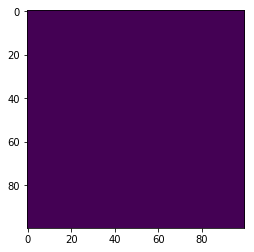

In [30]:
imshow(X_test[1000])

In [29]:
X_test.shape

(20000, 100, 100)

In [7]:
# generate images
N = 100
X = [np.zeros((N, 100, 100), dtype=np.float32), np.zeros((N, 100, 100), dtype=np.float32), np.zeros((N, 100, 100), dtype=np.float32)]
y = [np.zeros((N), dtype=np.float32), np.zeros((N), dtype=np.float32), np.zeros((N), dtype=np.float32)]

for x in range(3):
    FLAGS = [False] * 10 # never more than 10 flags
    for f in range(x):
      FLAGS[f] = True            
    print FLAGS
    
    for n in range(N):

        sparse, image, label, parameters = C.Figure1.direction(FLAGS)

        image = image.astype(np.float32)
        image += np.random.uniform(0, 0.05,(100,100))
            
        X[x][n] = image
        y[x][n] = label


[False, False, False, False, False, False, False, False, False, False]
[True, False, False, False, False, False, False, False, False, False]
[True, True, False, False, False, False, False, False, False, False]


In [8]:
# normalize
for i in range(3):
    

    X_min = X[i].min()
    X_max = X[i].max()

    # scale in place
    X[i] -= X_min
    X[i] /= (X_max - X_min)
    X[i] -= .5

    y_min = y[i].min()
    y_max = y[i].max()

    y[i] -= y_min
    y[i] /= (y_max - y_min)

0.491525


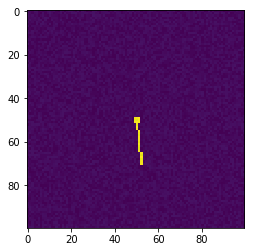

In [9]:
print y[0][10]
imshow(X[0][10]) # just direction

0.695402


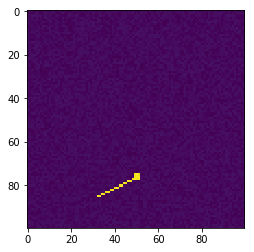

In [10]:
print y[1][10]
imshow(X[1][10]) # direction + Y

0.33908


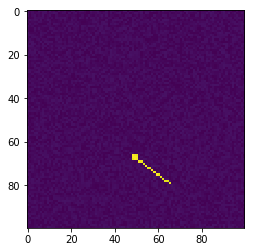

In [11]:
print y[2][10]
imshow(X[2][10]) # direction + Y + X

In [24]:
import sklearn.metrics
import keras.applications
results = [[-1]*3]*3

for data in range(3):
    
    for network in range(3):
        
        # make 3d
        X_new = np.stack((X[data],)*3, -1)
        
        feature_generator = keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(100,100,3))
        X_test_3D_features = feature_generator.predict(X_new, verbose=True)
        
        feature_shape = X_test_3D_features.shape[1]*X_test_3D_features.shape[2]*X_test_3D_features.shape[3]
        
        y_pred = networks[network].predict(X_test_3D_features.reshape(len(X_test_3D_features), feature_shape), \
                                           feature_shape)
        
        y_test = y[data]
        MLAE = np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test*100)+.125)

        print sklearn.metrics.mean_absolute_error(y_pred, y_test)
        
        print 'predicted data', data, 'with network', network, 'MLAE', MLAE

100/100 [==============================] - 2s 19ms/step
0.144911
predicted data 0 with network 0 MLAE 3.86948465265
100/100 [==============================] - 2s 21ms/step
0.167929
predicted data 0 with network 1 MLAE 4.08047534859
100/100 [==============================] - 2s 22ms/step
0.265282
predicted data 0 with network 2 MLAE 4.73623437944
100/100 [==============================] - 2s 23ms/step
0.229504
predicted data 1 with network 0 MLAE 4.52828275976
100/100 [==============================] - 2s 24ms/step
0.180192
predicted data 1 with network 1 MLAE 4.18143618961
100/100 [==============================] - 3s 25ms/step
0.255247
predicted data 1 with network 2 MLAE 4.68087123635
100/100 [==============================] - 3s 25ms/step
0.324238
predicted data 2 with network 0 MLAE 5.0245326825
100/100 [==============================] - 3s 27ms/step
0.301148
predicted data 2 with network 1 MLAE 4.91837612292
100/100 [==============================] - 3s 29ms/step
0.300845
predicte

In [21]:
X[0].max()

0.5

In [79]:
np.log2(40)

5.3219280948873626

In [463]:
import keras.backend as K

#
# CODE BELOW FROM https://github.com/philipperemy/keras-visualize-activations
#
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


def display_activations(activation_maps, outputprefix=None):
    import numpy as np
    import matplotlib.pyplot as plt
    """
    (1, 26, 26, 32)
    (1, 24, 24, 64)
    (1, 12, 12, 64)
    (1, 12, 12, 64)
    (1, 9216)
    (1, 128)
    (1, 128)
    (1, 10)
    """
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
#             if num_activations > 1024:  # too hard to display it on the screen.
#                 square_param = int(np.floor(np.sqrt(num_activations)))
#                 activations = activations[0: square_param * square_param]
#                 activations = np.reshape(activations, (square_param, square_param))
#             else:
            activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.figure(figsize=(20,10))
        plt.imshow(activations)
        ax = plt.gca()
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        from matplotlib.ticker import NullFormatter
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_ticks_position('none') 
#         if outputprefix:
#             plt.savefig(outputprefix+str(i)+'.png', bbox_inches='tight', pad_inches=0)
#             print 'stored', outputprefix+str(i)+'.png'
#         plt.show()
        return activations

def show_nicely(data,filename=None,cmap='jet'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    plt.figure(figsize=(20,10))
    im = plt.imshow(data, cmap=cmap)
    ax = plt.gca()
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    from matplotlib.ticker import NullFormatter
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_ticks_position('none') 

    # create an axes on the right side of ax. The width of cax will be 5%
#     # of ax and the padding between cax and ax will be fixed at 0.05 inch.
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="2%", pad=0.05)
#     cax.yaxis.set_major_formatter(NullFormatter())
#     cax.yaxis.set_ticks_position('none') 

#     plt.colorbar(im, cax=cax)
    if filename:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)

In [29]:
import os, sys, time
import cPickle as pickle
sys.path.append('../EXP/')
import ClevelandMcGill as C
reload(C)

<module 'ClevelandMcGill' from '../EXP/ClevelandMcGill/__init__.pyc'>

In [264]:
X_bar = np.zeros((1, 100, 100), dtype=np.float32)
X_pie = np.zeros((1, 100, 100), dtype=np.float32)
y = np.zeros((1,5), dtype=np.float32)

for n in range(1):
    data,label = C.Figure3.generate_datapoint()

    image = C.Figure3.data_to_piechart(data)
    # we need float
    image = image.astype(np.float32)
    image += np.random.uniform(0, 0.05,(100,100))
    X_pie[n] = image
    
    image = C.Figure3.data_to_barchart(data)
    # we need float
    image = image.astype(np.float32)
    image += np.random.uniform(0, 0.05,(100,100))
    X_bar[n] = image
    
    y[n] = label
    
X_min = X_bar.min()
X_max = X_bar.max()
X_bar -= X_min
X_bar /= (X_max - X_min)
X_bar -= .5

X_min = X_pie.min()
X_max = X_pie.max()
X_pie -= X_min
X_pie /= (X_max - X_min)
X_pie -= .5

# y_min = y.min()
# y_max = y.max()
# y -= y_min
# y /= (y_max - y_min)

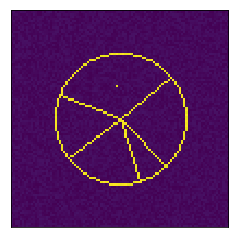

In [327]:
imshow(X_pie[0])
ax = plt.gca()
ax.set_xticklabels('')
ax.set_yticklabels('')
from matplotlib.ticker import NullFormatter
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_ticks_position('none') 
plt.savefig('../PAPER/gfx/teaser_pie.pdf', bbox_inches='tight', pad_inches=0)

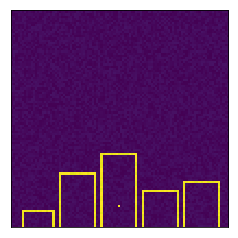

In [328]:
imshow(X_bar[0])
ax = plt.gca()
ax.set_xticklabels('')
ax.set_yticklabels('')
from matplotlib.ticker import NullFormatter
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_ticks_position('none') 
plt.savefig('../PAPER/gfx/teaser_bar.pdf', bbox_inches='tight', pad_inches=0)

In [472]:
print 'bar', model_bar.predict(X_bar.reshape(len(X_pie), 100, 100, 1))
print 'pie', model_pie.predict(X_pie.reshape(len(X_pie), 100, 100, 1))
print 'GT', y[0]

bar [[ 1.00376546  0.3950626   0.55636054  0.1258707   0.70096749]]
pie [[ 0.99375713  0.4542599   0.5070948   0.36533445  0.52434176]]
GT [ 1.          0.4848485   0.60606062  0.21212122  0.72727275]


In [478]:
import sklearn.metrics
bar_e = sklearn.metrics.mean_squared_error(model_bar.predict(X_bar.reshape(len(X_bar), 100, 100, 1))[0], y[0])
pie_e = sklearn.metrics.mean_squared_error(model_pie.predict(X_pie.reshape(len(X_pie), 100, 100, 1))[0], y[0])
print 'Bar MSE', bar_e
print 'Pie MSE', pie_e

Bar MSE 0.00373538
Pie MSE 0.0150848


In [405]:
outputs_pie_conv2d_1 = get_activations(model_pie, X_pie.reshape(len(X_pie), 100, 100, 1), layer_name='conv2d_1', print_shape_only=True)
outputs_pie_conv2d_2 = get_activations(model_pie, X_pie.reshape(len(X_pie), 100, 100, 1), layer_name='conv2d_2', print_shape_only=True)

----- activations -----
(1, 100, 100, 20)
----- activations -----
(1, 50, 50, 50)


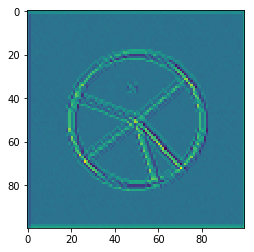

In [332]:
imshow(outputs_pie[0][0,:,:,0])

Displaying activation map 0
Displaying activation map 0


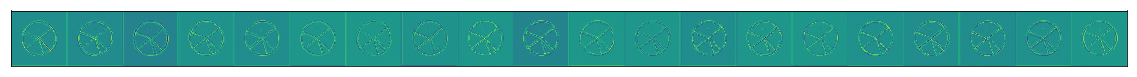

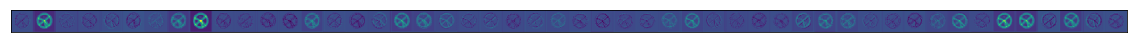

In [406]:
outputs_pie_conv2d_1_vis = display_activations(outputs_pie_conv2d_1, outputprefix='../PAPER/gfx/teaser_pie_activations_conv2d_1_')
outputs_pie_conv2d_2_vis = display_activations(outputs_pie_conv2d_2, outputprefix='../PAPER/gfx/teaser_pie_activations_conv2d_1_')

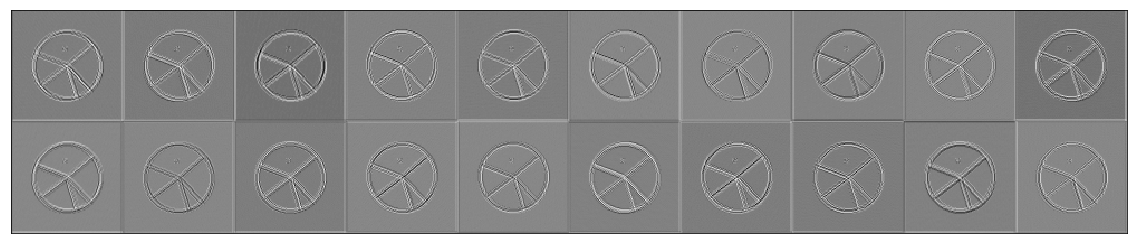

In [464]:
vis = outputs_pie_conv2d_1_vis
vis2 = np.zeros((vis.shape[0]*2, vis.shape[1]/2))
vis2[0:vis.shape[0], 0:vis2.shape[1]] = vis[:,:vis2.shape[1]]
vis2[vis.shape[0]:, 0:vis2.shape[1]] = vis[:,vis2.shape[1]:]
vis2 *= 1./vis2.max()
vis2 /= vis2.max()/1.
show_nicely(vis2,cmap='gray',filename='teaser_pie_conv2d_1.')

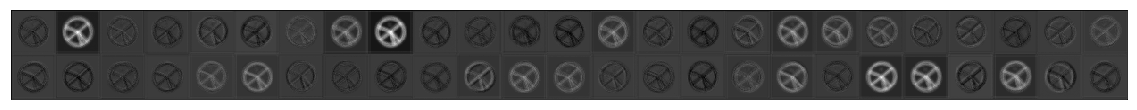

In [470]:
vis = outputs_pie_conv2d_2_vis
vis2 = np.zeros((vis.shape[0]*2, vis.shape[1]/2))
for i in range(2):
#     print i, i*vis2.shape[1],i*vis2.shape[1] + vis2.shape[1]
    vis2[i*vis.shape[0]:i*vis.shape[0] + vis.shape[0],\
         0:vis2.shape[1]] = vis[:,i*vis2.shape[1]:i*vis2.shape[1]+vis2.shape[1]]
# vis2[0:vis.shape[0], 0:vis2.shape[1]] = vis[:,:vis2.shape[1]]
# vis2[vis.shape[0]:, 0:vis2.shape[1]] = vis[:,vis2.shape[1]:]
vis2 *= 1./vis2.max()
vis2 /= vis2.max()/1.
show_nicely(vis2,cmap='gray',filename='teaser_pie_conv2d_2.')

In [459]:
outputs_bar_conv2d_1 = get_activations(model_bar, X_bar.reshape(len(X_bar), 100, 100, 1), layer_name='conv2d_1', print_shape_only=True)
outputs_bar_conv2d_2 = get_activations(model_bar, X_bar.reshape(len(X_bar), 100, 100, 1), layer_name='conv2d_2', print_shape_only=True)

----- activations -----
(1, 100, 100, 20)
----- activations -----
(1, 50, 50, 50)


Displaying activation map 0
Displaying activation map 0


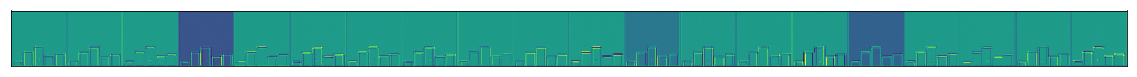

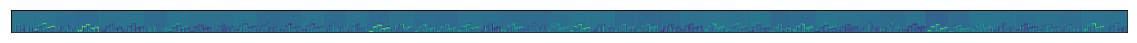

In [460]:
outputs_bar_conv2d_1_vis = display_activations(outputs_bar_conv2d_1, outputprefix='../PAPER/gfx/teaser_bar_activations_conv2d_1_')
outputs_bar_conv2d_2_vis = display_activations(outputs_bar_conv2d_2, outputprefix='../PAPER/gfx/teaser_bar_activations_conv2d_1_')

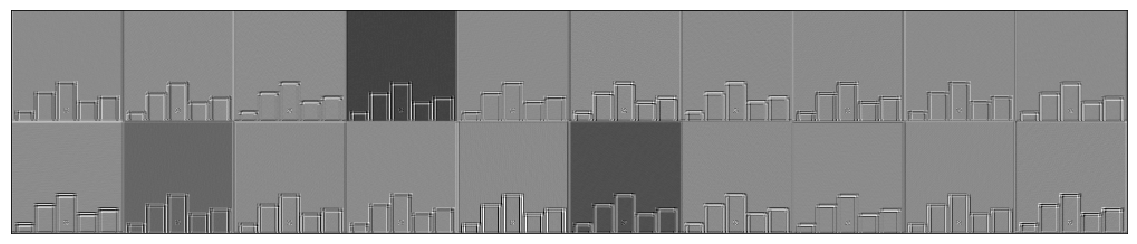

In [467]:
vis = outputs_bar_conv2d_1_vis
vis2 = np.zeros((vis.shape[0]*2, vis.shape[1]/2))
vis2[0:vis.shape[0], 0:vis2.shape[1]] = vis[:,:vis2.shape[1]]
vis2[vis.shape[0]:, 0:vis2.shape[1]] = vis[:,vis2.shape[1]:]
vis2 *= 1./vis2.max()
vis2 /= vis2.max()/1.
show_nicely(vis2,cmap='gray',filename='teaser_bar_conv2d_1.')

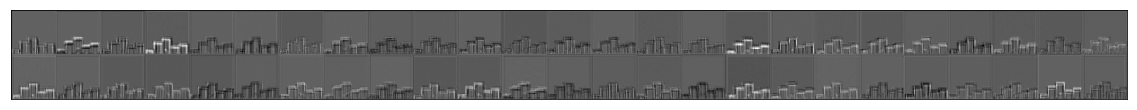

In [471]:
vis = outputs_bar_conv2d_2_vis
vis2 = np.zeros((vis.shape[0]*2, vis.shape[1]/2))
for i in range(2):
#     print i, i*vis2.shape[1],i*vis2.shape[1] + vis2.shape[1]
    vis2[i*vis.shape[0]:i*vis.shape[0] + vis.shape[0],\
         0:vis2.shape[1]] = vis[:,i*vis2.shape[1]:i*vis2.shape[1]+vis2.shape[1]]
# vis2[0:vis.shape[0], 0:vis2.shape[1]] = vis[:,:vis2.shape[1]]
# vis2[vis.shape[0]:, 0:vis2.shape[1]] = vis[:,vis2.shape[1]:]
vis2 *= 1./vis2.max()
vis2 /= vis2.max()/1.
show_nicely(vis2,cmap='gray',filename='teaser_bar_conv2d_2.')

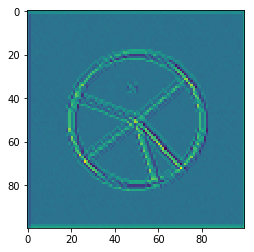

In [335]:
imshow(outputs_pie[0][0,:,:,0])

Displaying activation map 0
stored ../PAPER/gfx/teaser_bar_activations_0.png


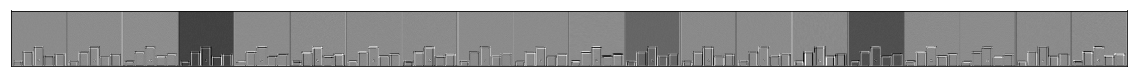

Displaying activation map 1
stored ../PAPER/gfx/teaser_bar_activations_1.png


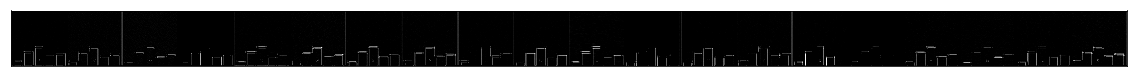

Displaying activation map 2
stored ../PAPER/gfx/teaser_bar_activations_2.png


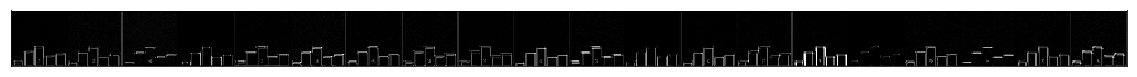

Displaying activation map 3
stored ../PAPER/gfx/teaser_bar_activations_3.png


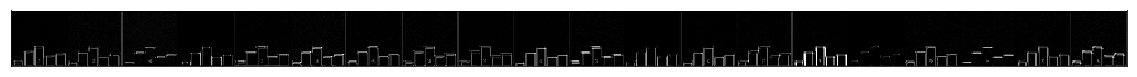

Displaying activation map 4
stored ../PAPER/gfx/teaser_bar_activations_4.png


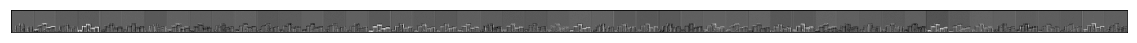

Displaying activation map 5
stored ../PAPER/gfx/teaser_bar_activations_5.png


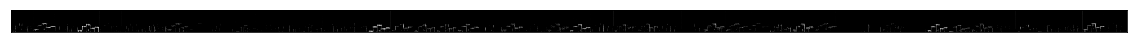

Displaying activation map 6
stored ../PAPER/gfx/teaser_bar_activations_6.png


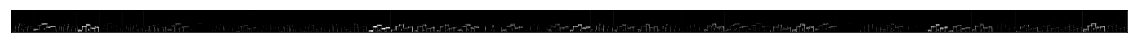

Displaying activation map 7
stored ../PAPER/gfx/teaser_bar_activations_7.png


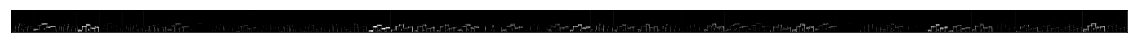

Displaying activation map 8
stored ../PAPER/gfx/teaser_bar_activations_8.png


Displaying activation map 9
stored ../PAPER/gfx/teaser_bar_activations_9.png


Displaying activation map 10
stored ../PAPER/gfx/teaser_bar_activations_10.png


Displaying activation map 11
stored ../PAPER/gfx/teaser_bar_activations_11.png


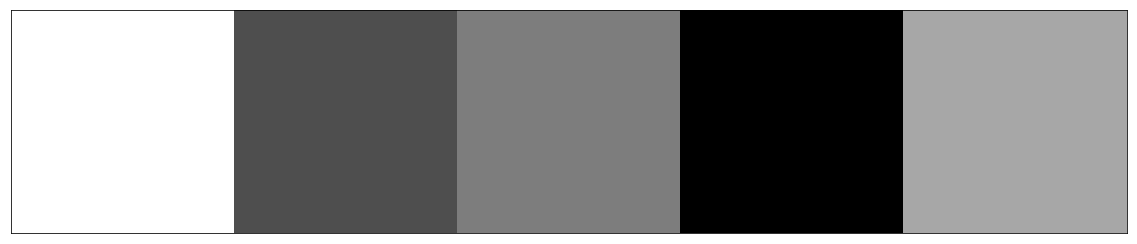

In [344]:
vis = display_activations(outputs_bar, outputprefix='../PAPER/gfx/teaser_bar_activations_')

In [322]:
W = model_pie.layers[4].get_weights()

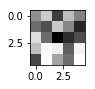

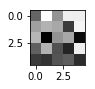

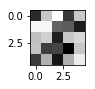

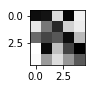

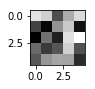

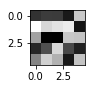

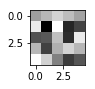

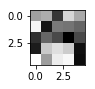

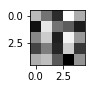

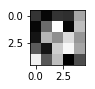

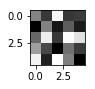

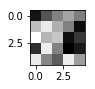

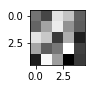

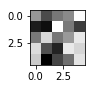

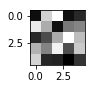

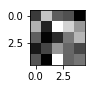

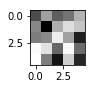

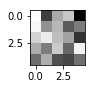

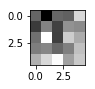

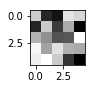

In [326]:
for i in range(20):
    plt.figure(figsize=(1,1))
    imshow(W[0][:,:,0,i],cmap='gray')